In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import dask 
import pandas as pd
import xrft 
import seawater as sw
from scipy.interpolate import griddata
from matplotlib import ticker

import os.path as op

from dask.diagnostics import ProgressBar
from scipy.ndimage import gaussian_filter as gauss

In [2]:
xmon=-1

path='/data/pacific/lrenault/SASI/FULL/WRF/'
listm=glob(path+'*DAY.nc');listm.sort()
varf=xr.open_dataset(listm[-9:][xmon])


path='/data/pacific/lrenault/SASI/SMTH/WRF/'
listt=glob(path+'*DAY.nc');listt.sort()
vart=xr.open_dataset(listt[xmon])


In [15]:
vart

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, lev_M: 49, lev_W: 50, time_counter: 31, x: 300, y: 390)
Coordinates:
    nav_lat               (y, x) float32 ...
    nav_lon               (y, x) float32 ...
  * lev_M                 (lev_M) float32 1.0 2.0 3.0 4.0 ... 47.0 48.0 49.0
  * lev_W                 (lev_W) float32 1.0 2.0 3.0 4.0 ... 48.0 49.0 50.0
    time_centered         (time_counter) datetime64[ns] ...
  * time_counter          (time_counter) datetime64[ns] 2012-07-01T12:00:00 ....
Dimensions without coordinates: axis_nbounds, x, y
Data variables:
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] ...
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] ...
    T2                    (time_counter, y, x) float32 ...
    Q2                    (time_counter, y, x) float32 ...
    RAINCV                (time_counter, y, x) float32 ...
    RAINNCV               (time_counter, y, x) float32 ...
    RAIN                  (time_counter, y, x) float32 ...
    GLW                   (time_counter, y, x) float32 ...
    GSW                   (time_counter, y, x) float32 ...
    LH                    (time_counter, y, x) float32 ...
    HFX                   (time_counter, y, x) float32 ...
    UST                   (time_counter, y, x) float32 ...
    U10                   (time_counter, y, x) float32 0.8292 0.8383 ... 0.6947
    V10                   (time_counter, y, x) float32 -5.139 -5.245 ... 0.01251
    SST                   (time_counter, y, x) float32 ...
    WSPD10                (time_counter, y, x) float32 ...
    UOCE                  (time_counter, y, x) float32 -0.1335 -0.1349 ... 0.0
    VOCE                  (time_counter, y, x) float32 -0.1363 -0.1384 ... 0.0
    ZNT                   (time_counter, y, x) float32 ...
    XKMV                  (time_counter, lev_M, y, x) float32 ...
    XKMH                  (time_counter, lev_M, y, x) float32 ...
    XKHV                  (time_counter, lev_M, y, x) float32 ...
    XKHH                  (time_counter, lev_M, y, x) float32 ...
    BN2                   (time_counter, lev_M, y, x) float32 ...
    AKMS                  (time_counter, y, x) float32 ...
    AKHS                  (time_counter, y, x) float32 ...
    EXCH_H                (time_counter, lev_W, y, x) float32 ...
    EXCH_M                (time_counter, lev_W, y, x) float32 ...
Attributes:
    name:                            Out/wrf_3D_Y2012M07_DAY
    description:                     wrf M grid variables
    title:                           wrf M grid variables
    Conventions:                     CF-1.6
    timeStamp:                       2020-Aug-07 23:22:58 GMT
    uuid:                            fadf5690-fd7a-41f7-8624-bb79a5918b6b
    TITLE:                           OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      2012-07-01_00:00:00
    SIMULATION_START_DATE:           2012-07-01_00:00:00
    DX:                              2000.0
    DY:                              2000.0
    AERCU_OPT:                       0
    AERCU_FCT:                       1.0
    IDEAL_CASE:                      0
    DIFF_6TH_SLOPEOPT:               0
    AUTO_LEVELS_OPT:                 2
    DIFF_6TH_THRESH:                 0.1
    DZBOT:                           20.0
    DZSTRETCH_S:                     1.3
    DZSTRETCH_U:                     1.1
    SKEBS_ON:                        0
    SPEC_BDY_FINAL_MU:               1
    USE_Q_DIABATIC:                  0
    GRIDTYPE:                        C
    SURFACE_INPUT_SOURCE:            1
    SST_UPDATE:                      1
    GRID_FDDA:                       0
    GFDDA_INTERVAL_M:                0
    GFDDA_END_H:                     0
    GRID_SFDDA:                      0
    SGFDDA_INTERVAL_M:               0
    SGFDDA_END_H:                    0
    HYPSOMETRIC_OPT:                 2
    USE_THETA_M:                     1
    SF_URBAN_PHYSICS:                0
    SF_SURFACE_MOSAI

In [3]:
plt.rcParams['font.size']=15
plt.rcParams['font.sans-serif']='Arial'
plt.rcParams['font.weight']='bold'

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


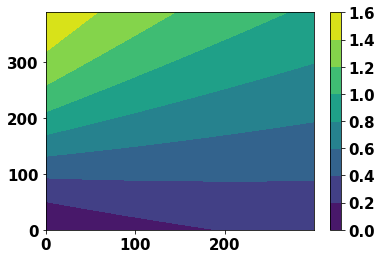

In [4]:
plt.figure()
plt.contourf(np.arctan2(varf.nav_lat-varf.nav_lat.min(),varf.nav_lon-varf.nav_lon.min()))
plt.colorbar()


In [5]:
ang = np.arctan2(varf.nav_lat-varf.nav_lat.min(),varf.nav_lon-varf.nav_lon.min()).mean()
X = np.exp(-1j*ang)*(varf.nav_lon-varf.nav_lon.mean() + 1j*(varf.nav_lat-varf.nav_lat.mean()))
xrot,yrot = X.real.mean('y'),X.imag.mean('x')

xrr=np.linspace(xrot.min()*111e3,xrot.max()*111e3,len(xrot))
yrr=np.linspace(yrot.min()*111e3,yrot.max()*111e3,len(yrot))

In [6]:
# af = varf.SST[xday].assign_coords(xrot=xrot,yrot=yrot).drop(['nav_lat','nav_lon'])
# at = vart.SST[xday].assign_coords(xrot=xrot,yrot=yrot).drop(['nav_lat','nav_lon'])
xday=15

Kf=0.5*(varf.UOCE**2+ varf.VOCE**2)
Kt=0.5*(vart.UOCE**2 +vart.VOCE**2)


af = Kf[xday][:,0:200].assign_coords(x=xrr[0:200],y=yrr).drop(['nav_lat','nav_lon'])
at = Kt[xday][:,0:200].assign_coords(x=xrr[0:200],y=yrr).drop(['nav_lat','nav_lon'])
# at.data=gauss(vart.SST[xday],5)





# af = xr.DataArray(varf.SST[xday].data,dims=('ya','xa'),coords={'xa':(('xa','ya'),xrot),'ya':(('xa','ya'),yrot)})

# at = xr.DataArray(vart.SST[xday].data,dims=('ya','xa'),coords={'xa':(('xa','ya'),xrot),'ya':(('xa','ya'),yrot)})


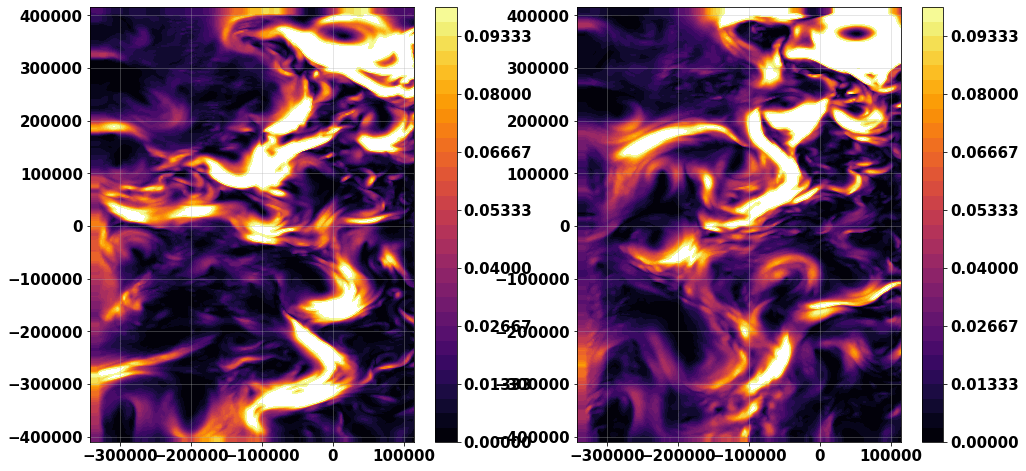

In [7]:

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.contourf(af.x,af.y,af,levels=np.linspace(0,0.1,31),cmap='inferno')
plt.grid(alpha=0.4)
plt.colorbar()

plt.subplot(1,2,2)
plt.contourf(at.x,af.y,at,levels=np.linspace(0,0.1,31),cmap='inferno')
plt.grid(alpha=0.4)
plt.colorbar()




In [8]:
full_ps = xrft.power_spectrum(af,dim=["x","y"])
smth_ps = xrft.power_spectrum(at,dim=["x","y"])


iso_f = xrft.isotropic_powerspectrum(af, dim=['x','y'],detrend='constant')
iso_t = xrft.isotropic_powerspectrum(at, dim=['x','y'],detrend='constant')


fy=smth_ps.freq_y
fx=smth_ps.freq_x

fx,fy=np.meshgrid(fx,fy)

/opt/anaconda3/lib/python3.8/site-packages/xrft/xrft.py:1063: Warning: This function has been renamed and will disappear in the future. Please use isotropic_power_spectrum instead
  warnings.warn(msg, Warning)
/opt/anaconda3/lib/python3.8/site-packages/xrft/xrft.py:1041: FutureWarning: The flag `truncate` will be set to True by default in future version in order to truncate the isotropic wavenumber larger than the Nyquist wavenumber.
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/xrft/xrft.py:1063: Warning: This function has been renamed and will disappear in the future. Please use isotropic_power_spectrum instead
  warnings.warn(msg, Warning)
/opt/anaconda3/lib/python3.8/site-packages/xrft/xrft.py:1041: FutureWarning: The flag `truncate` will be set to True by default in future version in order to truncate the isotropic wavenumber larger than the Nyquist wavenumber.
  warnings.warn(msg, FutureWarning)


([<matplotlib.axis.XTick at 0x7f26fc9e1a90>,
 [Text(0, 0, '10$^3$'), Text(0, 0, '10$^4$'), Text(0, 0, '10$^5$')])

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


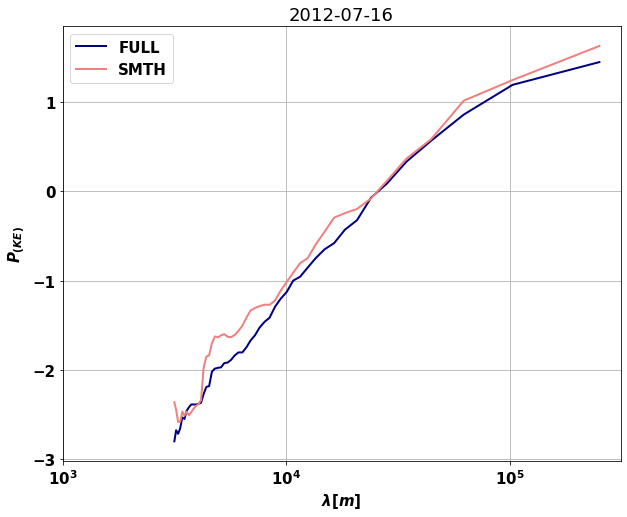

In [9]:

# plt.figure(figsize=(23,6))
# plt.subplot(1,3,1)
# plt.contourf(fx,fy,np.log(full_ps),levels=np.linspace(0,24,51),cmap='rainbow')
# plt.colorbar()
# plt.title('FULL')

# plt.subplot(1,3,2)
# plt.contourf(fx,fy,np.log(smth_ps),levels=np.linspace(0,24,51),cmap='rainbow')
# plt.colorbar()
# plt.title('SMTH')

# plt.subplot(1,3,3)
# plt.contourf(fx,fy,full_ps-smth_ps,levels=np.linspace(-1000,1000,51),cmap='seismic')
# plt.colorbar()
# plt.title('FULL - SMTH')



# plt.figure(figsize=(10,8))
# plt.plot(np.log10(2*np.pi/iso_f.freq_r),np.log10(iso_f),label='FULL',linewidth=2,color='navy')
# plt.plot(np.log10(2*np.pi/iso_f.freq_r),np.log10(iso_t),label='SMTH',linewidth=2,color='lightcoral')
# plt.ylabel(r'$P_{(SST)}$')
# # plt.xlabel(r'$\lambda$ [km]')
# plt.legend()
# plt.grid()
# # plt.xlim(0,10)


plt.figure(figsize=(10,8))
plt.plot(np.log10(1/iso_f.freq_r),np.log10(iso_f),label='FULL',linewidth=2,color='navy')
plt.plot(np.log10(1/iso_f.freq_r),np.log10(iso_t),label='SMTH',linewidth=2,color='lightcoral')
plt.ylabel(r'$P_{(KE)}$')
# plt.xlabel(r'$\lambda$ [km]')
plt.legend()
plt.grid()
plt.title(np.datetime_as_string(varf.time_counter[xday].data)[:10])
plt.xlabel(r'$\lambda [m]$')
plt.xticks(np.arange(3,6,1),[r'10$^3$',r'10$^4$',r'10$^5$'])
# plt.xlim(0,10)

# plt.figure()
# plt.plot(iso_f-iso_t)

# plt.figure(figsize=(10,8))
# plt.plot(1/iso_f.freq_r,iso_f,norm='logNorm()',label='FULL',linewidth=2,color='navy')
# plt.plot(np.log(1/iso_f.freq_r),np.log(iso_t),label='SMTH',linewidth=2,color='lightcoral')
# plt.ylabel(r'$P_{(SST)}$')
# # plt.xlabel(r'$\lambda$ [km]')
# plt.legend()
# plt.grid()
# plt.ylim(3,5)







In [10]:
# af = varf.SST[xday].assign_coords(xrot=xrot,yrot=yrot).drop(['nav_lat','nav_lon'])
# at = vart.SST[xday].assign_coords(xrot=xrot,yrot=yrot).drop(['nav_lat','nav_lon'])
xday=15

Kfw=0.5*(varf.U10**2+ varf.V10**2)
Ktw=0.5*(vart.U10**2 +vart.V10**2)


wf = Kfw[xday][:,0:200].assign_coords(x=xrr[0:200],y=yrr).drop(['nav_lat','nav_lon'])
wt = Ktw[xday][:,0:200].assign_coords(x=xrr[0:200],y=yrr).drop(['nav_lat','nav_lon'])
# at.data=gauss(vart.SST[xday],5)

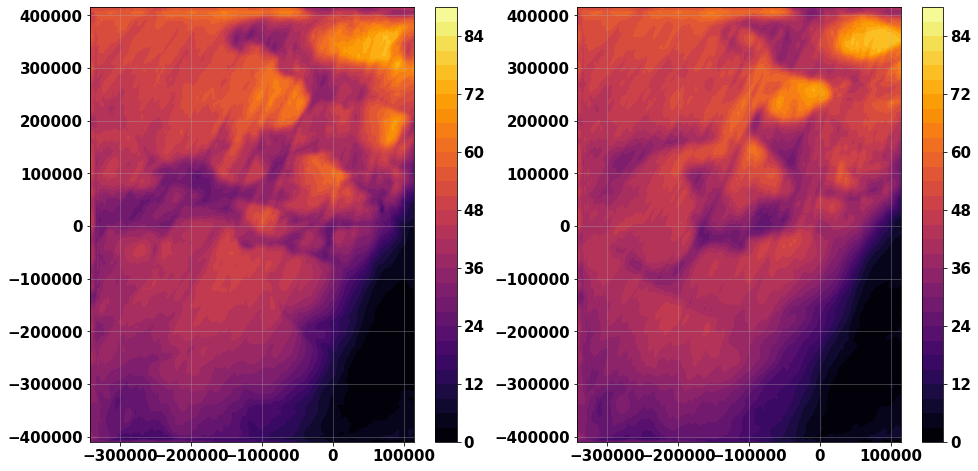

In [11]:

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.contourf(wf.x,wf.y,wf,levels=np.linspace(0,90,31),cmap='inferno')
plt.grid(alpha=0.4)
plt.colorbar()

plt.subplot(1,2,2)
plt.contourf(wt.x,wf.y,wt,levels=np.linspace(0,90,31),cmap='inferno')
plt.grid(alpha=0.4)
plt.colorbar()



In [12]:
full_ps = xrft.power_spectrum(wf,dim=["x","y"])
smth_ps = xrft.power_spectrum(wt,dim=["x","y"])


iso_f = xrft.isotropic_powerspectrum(wf, dim=['x','y'],detrend='constant')
iso_t = xrft.isotropic_powerspectrum(wt, dim=['x','y'],detrend='constant')


fy=smth_ps.freq_y
fx=smth_ps.freq_x


fx,fy=np.meshgrid(fx,fy)

/opt/anaconda3/lib/python3.8/site-packages/xrft/xrft.py:1063: Warning: This function has been renamed and will disappear in the future. Please use isotropic_power_spectrum instead
  warnings.warn(msg, Warning)
/opt/anaconda3/lib/python3.8/site-packages/xrft/xrft.py:1041: FutureWarning: The flag `truncate` will be set to True by default in future version in order to truncate the isotropic wavenumber larger than the Nyquist wavenumber.
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/xrft/xrft.py:1063: Warning: This function has been renamed and will disappear in the future. Please use isotropic_power_spectrum instead
  warnings.warn(msg, Warning)
/opt/anaconda3/lib/python3.8/site-packages/xrft/xrft.py:1041: FutureWarning: The flag `truncate` will be set to True by default in future version in order to truncate the isotropic wavenumber larger than the Nyquist wavenumber.
  warnings.warn(msg, FutureWarning)


([<matplotlib.axis.XTick at 0x7f26fa91ebb0>,
 [Text(0, 0, '10$^3$'), Text(0, 0, '10$^4$'), Text(0, 0, '10$^5$')])

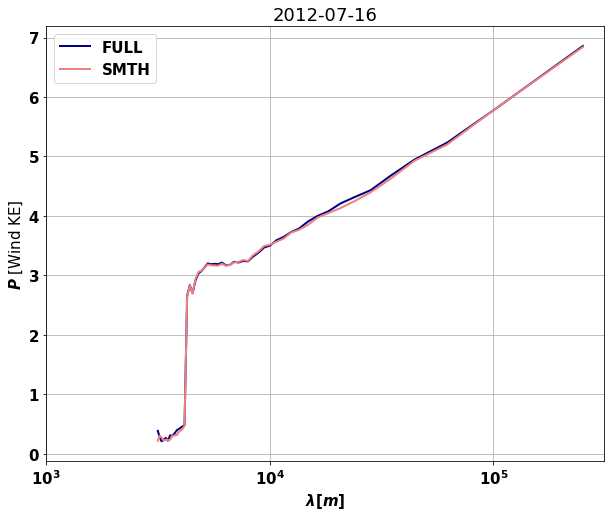

In [13]:


plt.figure(figsize=(10,8))
plt.plot(np.log10(1/iso_f.freq_r),np.log10(iso_f),label='FULL',linewidth=2,color='navy')
plt.plot(np.log10(1/iso_f.freq_r),np.log10(iso_t),label='SMTH',linewidth=2,color='lightcoral')
plt.ylabel(r'$P$ [Wind KE]')
# plt.xlabel(r'$\lambda$ [km]')
plt.legend()
plt.grid()
plt.title(np.datetime_as_string(varf.time_counter[xday].data)[:10])
plt.xlabel(r'$\lambda [m]$')
plt.xticks(np.arange(3,6,1),[r'10$^3$',r'10$^4$',r'10$^5$'])
# plt.xlim(0,10)

